In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import os
from sklearn.preprocessing import StandardScaler
from multiprocessing import cpu_count

In [2]:
# Load data into memory
# These datasets come come pre-packaged with colab, so it's best to run this lesson there.
housing = pd.read_csv('sample_data/california_housing_train.csv')
housing_test = pd.read_csv('sample_data/california_housing_test.csv')

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [4]:
housing.agg(['mean','std'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387


In [5]:
x_train = housing.drop('median_house_value', axis=1)
y_train = housing.median_house_value.values

x_valid = housing_test.drop('median_house_value', axis=1)
y_valid = housing_test.median_house_value.values

In [6]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

In [7]:
# Check that the means of each column are close to 0
assert np.allclose(x_train_scaled.mean(axis=0), np.zeros(x_train_scaled.shape[1]))
# Check that the stds of each column are close to 1
assert np.allclose(x_train_scaled.std(axis=0), np.ones(x_train_scaled.shape[1]))

In [8]:
class HousingDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        # What are some other ways we could do this?
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
train_ds = HousingDataset(x_train_scaled, y_train)
valid_ds = HousingDataset(x_valid_scaled, y_valid)

In [10]:
# What are the number of items in each dataset?
len(train_ds), len(valid_ds)

(17000, 3000)

In [11]:
# What is the x and y at a given index?
idx = 8

In [12]:
x, y = train_ds[idx]
x, y

(array([ 2.47972161, -0.94289358,  0.42987474,  0.98415173,  1.50796844,
         1.48492555,  1.44282004, -0.89375701]),
 np.float64(58400.0))

In [21]:
# Choose an index in your dataset
idx = 250
# Fetch an item at that index from train_ds
x, y = train_ds[idx]
# check that the x value is the same as the corresponding value from x_train_scaled at the same index
assert np.allclose(x, x_train_scaled[idx]), f"x values do not match: {x} vs {x_train_scaled[idx]}"
# assert (x == x_train_scaled[idx]).all()
# check that the y value is the same as the corresponding value from y_train at the same index
assert np.isclose(y, y_train[idx]), f"y values do not match: {y} vs {y_train[idx]}"
# assert y == y_train_scaled[idx]

In [22]:
BATCH_SIZE = 64
N_WORKERS = cpu_count()
print(f"""
In this example, each batch will contain {BATCH_SIZE} items.
We will use {N_WORKERS} workers to load data more efficiently.
""")


In this example, each batch will contain 64 items.
We will use 2 workers to load data more efficiently.



In [23]:
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True, # We generally want to shuffle the train dataloader
    num_workers=N_WORKERS
)

In [24]:
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

In [25]:
# Pull one batch of data
for batch in train_dl:
    break


# batch = next(iter(train_dl))


In [26]:
# What's the type? The length?
type(batch), len(batch)

(list, 2)

In [27]:
# This looks like our X
batch[0].shape

torch.Size([64, 8])

In [28]:
# This looks like our y
batch[1].shape

torch.Size([64])

In [29]:
for x_batch, y_batch in train_dl:
    break

  # x_batch, y_batch = next(iter(train_dl))

In [33]:
x_batch.shape, y_batch.shape

(torch.Size([64, 8]), torch.Size([64]))

In [34]:
x_batch

tensor([[-1.3854e+00,  1.1064e+00,  1.0655e+00, -5.1042e-01, -5.0633e-01,
         -1.3815e-01, -3.2307e-01, -6.6395e-01],
        [ 6.1947e-01, -8.3528e-01,  1.0655e+00, -5.3107e-01, -2.8331e-01,
         -4.6399e-01, -3.2307e-01, -1.1848e+00],
        [-1.0812e+00,  1.3731e+00,  1.1208e-01,  3.0384e-01,  2.1255e-01,
          1.6852e-01,  3.8173e-01, -5.3570e-01],
        [-1.3405e+00,  1.1345e+00,  1.1208e-01, -6.3704e-01, -5.7513e-01,
         -5.6679e-01, -5.0512e-01, -1.1566e+00],
        [ 5.5464e-01, -7.6510e-01,  1.3038e+00, -6.9346e-01, -6.4156e-01,
         -6.7569e-01, -6.1695e-01,  3.5833e-01],
        [ 6.4441e-01, -8.5867e-01,  8.2712e-01, -5.6272e-01, -4.2803e-01,
          1.7796e-02, -3.4907e-01, -5.4367e-01],
        [ 1.1531e+00, -1.1300e+00, -1.5564e+00, -3.2096e-01, -1.2197e-01,
          4.9000e-01, -1.2541e-01, -9.5256e-01],
        [-5.7248e-01,  2.1077e+00, -7.6187e-01, -8.0127e-01, -8.5272e-01,
         -1.0050e+00, -1.0175e+00, -4.8644e-01],
        [ 7.7408

In [35]:
y_batch

tensor([ 85100., 376100., 145200., 147700., 343100., 172000., 127200.,  89400.,
        212300.,  62000., 153300.,  73600., 500001., 262500., 143000.,  49400.,
        147000., 456600., 312500., 157800.,  98500., 400000., 235700.,  98700.,
        241500., 114300., 388100.,  88100.,  98900., 140600., 215700.,  91600.,
        182100.,  94900., 266300., 264100., 350000., 429300.,  88400., 113500.,
        161100., 155000., 276100., 441700.,  65800., 284800., 173300., 220100.,
        172600., 195400., 183800.,  87500., 115600., 246400., 256300., 337500.,
        187500.,  97900., 405000., 125000., 144900., 213900.,  97500.,  83600.],
       dtype=torch.float64)

In [36]:
total_samples = 0
total_batches = 0
batch_sizes = []
for x_b, y_b in train_dl:
  total_samples += len(x_b)
  batch_sizes.append(len(x_b))
  total_batches += 1
print(total_samples, total_batches, min(batch_sizes), max(batch_sizes))
try:
  train_dl[0]
except:
  print("We can't index into the train_dl object.")

17000 266 40 64
We can't index into the train_dl object.


We can't index into the batch because if something is shuffled and we pull something from memory, doesn't make sense to index into it. Maybe if we want specific instances of data. Not a practice supported by Torch

In [37]:
# We're just using fastai for the datasets for now.
# We'll learn how to use it for modeling later on.
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 782.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [38]:
# Download and extract the data
from fastai.data.all import URLs, untar_data
from fastcore.basics import Path
from PIL import Image
import numpy as np

path = untar_data(URLs.CIFAR)

In [41]:
# what files or directories are in the path variable?
print(path)
path.ls()


/root/.fastai/data/cifar10


(#3) [Path('/root/.fastai/data/cifar10/labels.txt'),Path('/root/.fastai/data/cifar10/train'),Path('/root/.fastai/data/cifar10/test')]

In [45]:
# what is contained in path/'train'?
(path/'train').ls()

(#10) [Path('/root/.fastai/data/cifar10/train/airplane'),Path('/root/.fastai/data/cifar10/train/dog'),Path('/root/.fastai/data/cifar10/train/truck'),Path('/root/.fastai/data/cifar10/train/bird'),Path('/root/.fastai/data/cifar10/train/automobile'),Path('/root/.fastai/data/cifar10/train/frog'),Path('/root/.fastai/data/cifar10/train/horse'),Path('/root/.fastai/data/cifar10/train/cat'),Path('/root/.fastai/data/cifar10/train/ship'),Path('/root/.fastai/data/cifar10/train/deer')]

In [48]:
# find the paths for 10 images of airplanes from the train dataset.
list((path/'train').ls())

[Path('/root/.fastai/data/cifar10/train/airplane'),
 Path('/root/.fastai/data/cifar10/train/dog'),
 Path('/root/.fastai/data/cifar10/train/truck'),
 Path('/root/.fastai/data/cifar10/train/bird'),
 Path('/root/.fastai/data/cifar10/train/automobile'),
 Path('/root/.fastai/data/cifar10/train/frog'),
 Path('/root/.fastai/data/cifar10/train/horse'),
 Path('/root/.fastai/data/cifar10/train/cat'),
 Path('/root/.fastai/data/cifar10/train/ship'),
 Path('/root/.fastai/data/cifar10/train/deer')]

In [49]:
def list_png_files(path):
    return list(path.glob('**/*.png'))

In [50]:
sample_files = list_png_files(path/'train')[:10]
sample_files

[Path('/root/.fastai/data/cifar10/train/airplane/41851_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/41821_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/41800_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/39904_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/13312_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/29515_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/41258_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/38716_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/28828_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/44794_airplane.png')]

In [51]:
def label_from_path_parent(path:Path) -> str:
    return path.parent.name

In [52]:
# Sanity check for label_from_parent_path
assert label_from_path_parent(Path('/root/.fastai/data/cifar10/train/horse/42500_horse.png')) == 'horse'

In [53]:
def load_image_and_label(path):
    img = Image.open(path)
    label = label_from_path_parent(path)
    return img, label

airplane


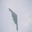

In [54]:
img, label = load_image_and_label(sample_files[0])
print(label)
img

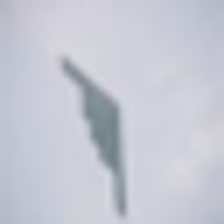

In [55]:
# Let's resize this image and inspect what it looks like
img.resize((224,224))

In [ ]:
class CifarDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.files = ...

    def __len__(self):
        return ...

    def __getitem__(self, idx):
        return ...

In [ ]:
train_cifar = CifarDataset(path/'train')

In [ ]:
img, label = train_cifar[8000]
print(label)
img.resize((224, 224))

In [ ]:
def img_to_scaled_tensor(img, channels_first=True):
    t = torch.tensor(np.array(img) / 255).float()
    if channels_first:
        return t.permute(2, 0, 1)
    return t

In [ ]:
img_t = img_to_scaled_tensor(img)
img_t.shape

In [ ]:
classes = {d.name:i  for i, d in enumerate((path/'train').ls())}
classes

In [ ]:
def class_to_idx(class_name):
    return classes.get(class_name)

In [ ]:
def collate_fn(batch):
    # The batch comes in the format ((x1, y1), (x2, y2), ..., (xn, yn)).
    # Let's split this up into our xs and our ys.
    xs, ys = list(zip(*batch))
    # Let's create a tensor that concatenates all our images on a new axis.
    # Is there another way to do this?
    xs = torch.cat([img_to_scaled_tensor(i).unsqueeze(0) for i in xs], dim=0)
    # Let's create another tensor that combines all our class labels.
    ys = torch.tensor([class_to_idx(i) for i in ys])

    return xs, ys

In [ ]:
# Test the collate function
items = (train_cifar[0], train_cifar[1])
items

In [ ]:
x_b, y_b = collate_fn(items)

In [ ]:
x_b.shape, y_b.shape

In [ ]:
train_cifar_dl = DataLoader(
    train_cifar,
    batch_size=BATCH_SIZE,
    num_workers=N_WORKERS,
    shuffle=True,
    collate_fn=collate_fn
)

In [ ]:
for x_b, y_b in train_cifar_dl:
    break

In [ ]:
x_b.shape

In [ ]:
y_b.shape